# Tel-Aviv rezoning feasibility evaluation

## Research objective
Tel-Aviv City had recently (January 2018) approved a new zoning plan for one of its city center precincts, **precinct no.3**, or **“The old North”** neighborhood, and is about to approve a similar rezoning for the neighbor **precinct no.4 (“The new North)**. The purpose of this research is to evaluate these two plans in terms of their **feasibility** and the future **floor/area ratio (FAR)** they would have formulate if fully implemented. This research attempts to assess whether the rezoning of these two precincts, although allowing more floor area to be built, **is feasible enough for developers to renew the buildings**.

# Imports

In [152]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [153]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Data aquiring

Data were aquired from [Tel-Aviv GIS](https://gisn.tel-aviv.gov.il/); 
- **Zoning plan no. 3616a** (Precinct 03) was selected
- Data were downloaded seperately for **_outside the White City Zone_** and **_inside the White City Zone_** (North and South to Arlozorov street). 
- _About **60%** of precinct 3 is **within the White City Zone.**_
- Within the plan's boundaries, the following layers were chosen and downloaded as _shapefiles_:
    - **Parcels** 
    - **Buildings** 
    - **Addresses**
    - **Historic Preservation**
    
    
- For each df, **commercial streets** were distinguished due to their different rezoning instructions.
- For each df, **historic preservation designated buildings** were excluded from the analysis (as these have different zoning).

# TLV shapefiles
## Precinct no.3 boundary

In [154]:
PCT3 = gpd.GeoDataFrame.from_file('data/boundary3/Quarters.shp')
PCT3.head()

oidrova  krova           dateimport     ShapeArea  \
0      3.0    3.0  01/12/2015 02:28:14  3.380430e+06   

                                            geometry  
0  POLYGON ((34.78366001782263 32.09671028569601,...

## the "White City" Zone 
A world heritage site declared by UNESCO at 2003 


In [155]:
# white city zone
whitecity = gpd.GeoDataFrame.from_file('data/all/whitecity/White City Zone.shp')
#whitecity = whitecity.drop(["oidktovet",'krechov','trechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'tktovetmel', 'dateimport', 'geometry'], axis = 1)
#whitecity.columns = [['idAddress', 'oldidAddress', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

whitecity.head()
# historic preservation

oidezor shemezor            tezor  kezor           dateimport  \
0      1.0   BUFFER  אזור חייץ הכרזה    4.0  17/01/2013 02:12:19   
1      2.0   ZONE A      אזור ההכרזה    1.0  17/01/2013 02:12:19   
2      3.0   BUFFER  אזור חייץ הכרזה    4.0  17/01/2013 02:12:19   
3      4.0   ZONE A      אזור ההכרזה    1.0  17/01/2013 02:12:19   
4      5.0   BUFFER  אזור חייץ הכרזה    4.0  17/01/2013 02:12:19   

                                            geometry  
0  POLYGON ((34.77010483312776 32.08548408809591,...  
1  POLYGON ((34.77053337341343 32.08536861271146,...  
2  POLYGON ((34.77010483312776 32.08548408809591,...  
3  POLYGON ((34.77053337341343 32.08536861271146,...  
4  POLYGON ((34.77063964786722 32.07718216118067,...

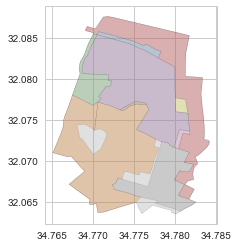

In [156]:
WC = whitecity.geometry
WC.plot(alpha=0.3, cmap='Set1', edgecolor='k')

In [157]:
import itertools
WC = WC.tolist()
type(WC)

list

In [158]:
auto_inter = gpd.overlay(whitecity, whitecity, how='intersection')
auto_inter.shape

/Applications/anaconda/lib/python3.6/site-packages/geopandas/base.py:75: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")


(76, 11)

In [159]:
type(auto_inter)

geopandas.geodataframe.GeoDataFrame

In [160]:
intersection = auto_inter
WCunion = intersection.unary_union

## Parcels precinct 3

In [161]:
# All precinct; in order to plot background for the city
parcelsshp = gpd.GeoDataFrame.from_file('data/all/parcelsshp/Parcels.shp')
parcelsshp = parcelsshp.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshp.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

parcelsshp.shape

(4560, 5)

### >> Precinct no.3 contains 4560 parcels.

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


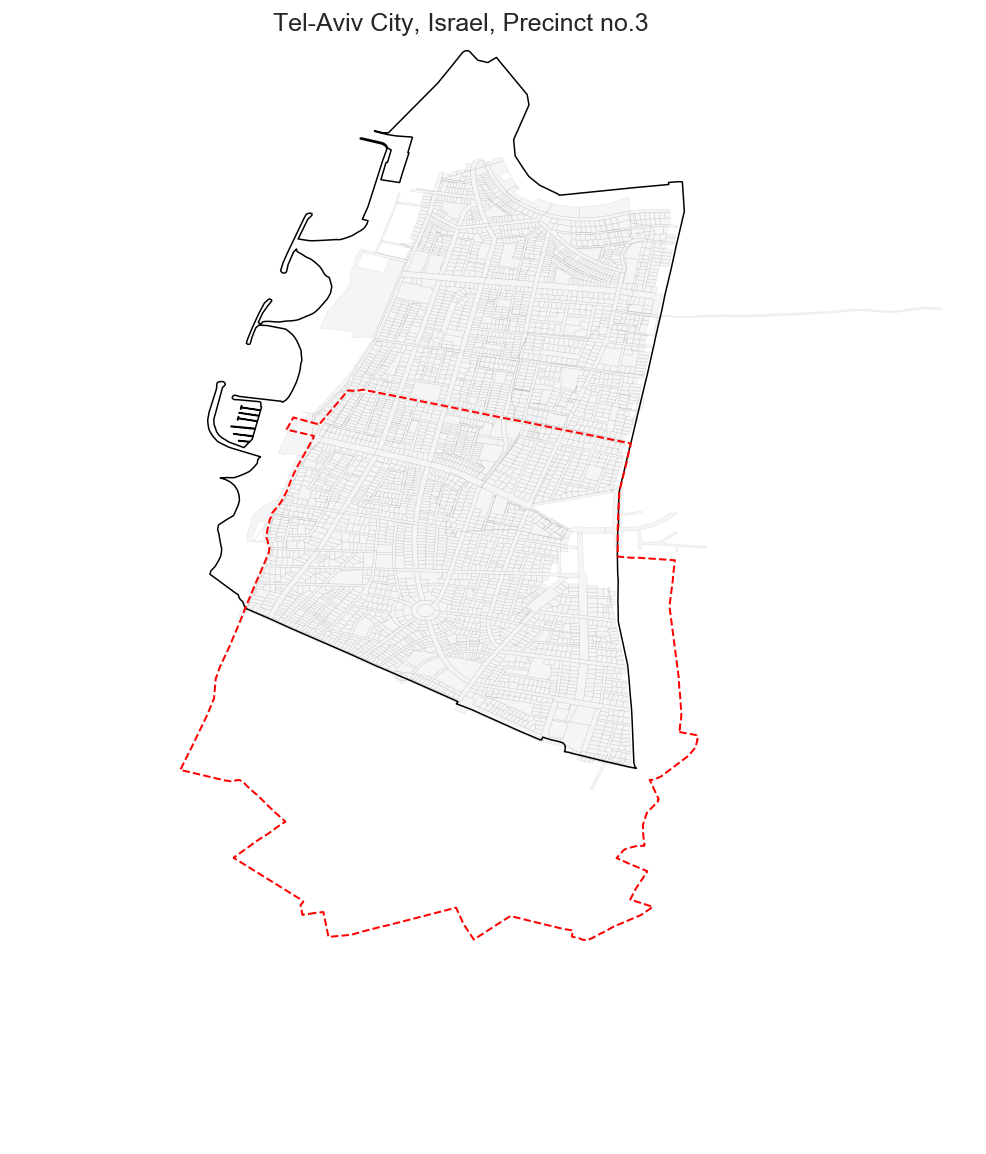

In [162]:
fig = pl.figure(figsize=(15,18))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)
PCT3.plot(ax=ax, color='none', edgecolor='k', linewidth=1.5)
gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',
                            linestyle='dashed', linewidth=2, label='White City zone')

ax.annotate('Precinct 3', xy=(10, 10), xytext=(10, 10),
            arrowprops=dict(facecolor='black', headwidth=0, 
                headlength=0, color='k'),color='k', fontsize=20)

plt.legend()
# ax.set_xlim(0,15)
# ax.set_ylim(0,18)
plt.title('Tel-Aviv City, Israel, Precinct no.3', size=25, y=.97, x=0.38)
tmp = ax.axis('off')

plt.savefig("TLV3.pdf", transparent=True)

### Fig.1 Precinct no.3, Tel-Aviv City, Israel
The **western boundary** is the **Mediterian Sea**; The **northern boundary** is **HaYarkon river**; The **Eastern boundary** is **Precinct no.4** (seperated by _Eben-Gvirol street_) and the **Southern boundary** is **Precinct no.5** (seperated by _Bugrashov street_).<br/>
The red dashed lines are the **"White City" Zone boundaries**. Zonings do not differ between the different areas of the White City. 

In [163]:
# Inside White City Zone
parcelsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Parcels.shp')
parcelsshpIN = parcelsshpIN.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpIN.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpIN['BBL'] = list(zip(parcelsshpIN.Block,parcelsshpIN.Parcel))
parcelsshpIN = parcelsshpIN.drop(['Block', 'Parcel'], axis=1)

parcelsshpIN.head()

idParcel  ParcelArea                                           geometry  \
0    2079.0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1    2081.0       284.0  POLYGON ((34.77344341891495 32.08711095658551,...   
2    2310.0         8.0  POLYGON ((34.77327859883683 32.0863077792844, ...   
3    2311.0        12.0  POLYGON ((34.77328772327471 32.08625947460223,...   
4    3208.0       281.0  POLYGON ((34.77303315814694 32.08714497353659,...   

               BBL  
0  (6902.0, 241.0)  
1  (6902.0, 116.0)  
2  (6902.0, 182.0)  
3  (6902.0, 185.0)  
4   (6902.0, 59.0)

In [164]:
parcelsshpIN.shape

(2769, 4)

In [165]:
# Outside White City Zone
parcelsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Parcels.shp')
parcelsshpOUT = parcelsshpOUT.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpOUT.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpOUT['BBL'] = list(zip(parcelsshpOUT.Block,parcelsshpOUT.Parcel))
parcelsshpOUT = parcelsshpOUT.drop(['Block', 'Parcel'], axis=1)

parcelsshpOUT.head()

idParcel  ParcelArea                                           geometry  \
0     467.0       282.0  POLYGON ((34.77856318885686 32.09408597755429,...   
1     469.0       275.0  POLYGON ((34.77912810593715 32.09412141266468,...   
2     471.0       417.0  POLYGON ((34.77570836899265 32.0941418815794, ...   
3     480.0       325.0  POLYGON ((34.77745222818285 32.09287050036341,...   
4     523.0       553.0  POLYGON ((34.78063465594656 32.09392296441273,...   

               BBL  
0   (6959.0, 32.0)  
1    (6957.0, 5.0)  
2  (6961.0, 106.0)  
3  (6959.0, 108.0)  
4   (6958.0, 34.0)

In [166]:
parcelsshpOUT.shape

(1911, 4)

In [167]:
# bar plot of white city / outside white city??



### >> About 60% of precinct no.3 parcels are within the _"White City" Zone_ (South to Arlozorov street)

## Buildings precinct 3

In [168]:
# Inside White City Zone

buildingsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Buildings.shp')
buildingsshpIN = buildingsshpIN.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpIN.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpIN.head()

idConst  idBuilding BuildingType  Floors   footprint  idBuildingOriginal  \
0  21336.0     22826.0  מבנה בבנייה     4.0  351.225764             66222.0   
1  21337.0     22827.0    מבנה רגיל     4.0  202.071150             66230.0   
2  21338.0     22828.0    מבנה רגיל     4.0  392.806769             69687.0   
3  21339.0     22829.0    מבנה רגיל     4.0  299.650683             65772.0   
4  21340.0     22830.0    מבנה רגיל     3.0  310.687994             65783.0   

   height  
0    16.0  
1    17.0  
2    18.0  
3    17.0  
4    18.0

In [169]:
buildingsshpIN.shape

(2563, 7)

In [173]:
buildingsshpIN[buildingsshpIN['BuildingType'] != 'מבנה רגיל'].shape

(260, 7)

In [170]:
# Outside White City Zone

buildingsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Buildings.shp')
buildingsshpOUT = buildingsshpOUT.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpOUT.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpOUT.head()

idConst  idBuilding BuildingType  Floors   footprint  idBuildingOriginal  \
0  20915.0     22392.0    מבנה רגיל     4.0  123.433980             74178.0   
1  20916.0     22394.0    מבנה רגיל     3.0  144.257155             79229.0   
2  20917.0     22395.0    מבנה רגיל     1.0   69.271012             56945.0   
3  20918.0     22396.0    מבנה רגיל     6.0  220.711618             55271.0   
4  20919.0     22397.0    מבנה רגיל     6.0  267.161697             74812.0   

   height  
0    15.0  
1    19.0  
2    22.0  
3    29.0  
4    23.0

In [171]:
buildingsshpOUT.shape

(1650, 7)

In [174]:
buildingsshpOUT[buildingsshpOUT['BuildingType'] != 'מבנה רגיל'].shape

(145, 7)

## Addresses precinct 3

In [70]:
# Inside White City Zone

AddressesIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Addresses.shp')
AddressesIN = AddressesIN.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesIN.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesIN['BBL'] = list(zip(AddressesIN.Block,AddressesIN.Parcel))
AddressesIN = AddressesIN.drop(['Block', 'Parcel'], axis=1)

AddressesIN.head()

idAddress  oldidAddress streetName       Address       AddressX  \
0    75906.0       75906.0      הפרדס       הפרדס 9  179454.431532   
1    74570.0       74570.0  בן גוריון  בן גוריון 59  178937.908125   
2    69885.0       69885.0      רופין      רופין 45  178556.837843   
3    73452.0       73452.0  שלמה המלך  שלמה המלך 93  179247.462858   
4    76166.0       76166.0  באר טוביה  באר טוביה 24  179015.080046   

        AddressY        lon        lat              BBL  
0  665746.201281  34.780725  32.084308  (6215.0, 294.0)  
1  665746.201281  34.775254  32.084291   (6954.0, 98.0)  
2  665746.154375  34.771218  32.084277   (6968.0, 68.0)  
3  665746.076311  34.778533  32.084300  (6215.0, 202.0)  
4  665744.451250  34.776071  32.084278   (6954.0, 89.0)

In [71]:
AddressesIN.shape

(2863, 9)

In [72]:
# Outside White City Zone

AddressesOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Addresses.shp')
AddressesOUT = AddressesOUT.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesOUT.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesOUT['BBL'] = list(zip(AddressesOUT.Block,AddressesOUT.Parcel))
AddressesOUT = AddressesOUT.drop(['Block', 'Parcel'], axis=1)

AddressesOUT.head()

idAddress  oldidAddress streetName      Address       AddressX  \
0    75400.0       75400.0       מיכה      מיכה 15  178988.400358   
1    73105.0       73105.0    דיזנגוף  דיזנגוף 294  179091.845656   
2    74069.0       74069.0    סוקולוב   סוקולוב 97  179242.033110   
3    74897.0       74897.0     יחזקאל    יחזקאל 17  179178.251875   
4    74710.0       74710.0     ישעיהו    ישעיהו 22  179330.033125   

        AddressY        lon        lat              BBL  
0  666805.232500  34.775744  32.093842   (6961.0, 67.0)  
1  666804.826250  34.776840  32.093842   (6959.0, 77.0)  
2  666803.560640  34.778431  32.093836   (6959.0, 40.0)  
3  666803.263765  34.777756  32.093831  (6959.0, 125.0)  
4  666801.732500  34.779363  32.093823    (6957.0, 9.0)

In [73]:
AddressesOUT.shape

(1878, 9)

## Historic Preservation designated buildings precinct 3

In [74]:
# Inside White City Zone

HistoricIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Historical Buildings.shp')
HistoricIN = HistoricIN.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricIN.head()

thatraa sttaba                            ktovot  \
0  שימור - בינלאומי  2650ב                        הירקון 118   
1  שימור - בינלאומי  2650ב  בן יהודה 96 ,גורדון יהודה ליב 24   
2  שימור - בינלאומי  2650ב                  הכרם 7 ,רופין 27   
3  שימור - בינלאומי  2650ב         בן גוריון 45 ,דיזנגוף 166   
4  שימור - בינלאומי  2650ב               בן גוריון 37 ,גרץ 1   

                                            geometry  
0  POLYGON ((34.76846874076895 32.08115666808349,...  
1  POLYGON ((34.77118473380646 32.08199703366387,...  
2  POLYGON ((34.77060031643551 32.08323174401378,...  
3  POLYGON ((34.77448150184389 32.08451973806656,...  
4  POLYGON ((34.77351286195784 32.08477260898684,...

In [75]:
HistoricIN.shape

(436, 4)

In [76]:
# Outside White City Zone

HistoricOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Historical Buildings.shp')
HistoricOUT = HistoricOUT.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricOUT.head()

thatraa sttaba                      ktovot  \
0  שימור - בינלאומי  2650ב  נורדאו 23 ,מיכה 2 ,מיכה 2א   
1  שימור - בינלאומי  2650ב                   נורדאו 15   
2  שימור - בינלאומי  2650ב                    נורדאו 9   
3  שימור - בינלאומי  2650ב                בן יהודה 201   
4  שימור - בינלאומי  2650ב                נחום הנביא 6   

                                            geometry  
0  POLYGON ((34.77573011759602 32.09261045347858,...  
1  POLYGON ((34.77435722680622 32.0927583013431, ...  
2  POLYGON ((34.77372277584232 32.09281543839031,...  
3  POLYGON ((34.77462431087153 32.09301221255826,...  
4  POLYGON ((34.77429674374923 32.09310789846018,...

In [77]:
HistoricOUT.shape

(45, 4)

### >> Most of the precinct's historic preservation designated buildings are within the "White City" Zone

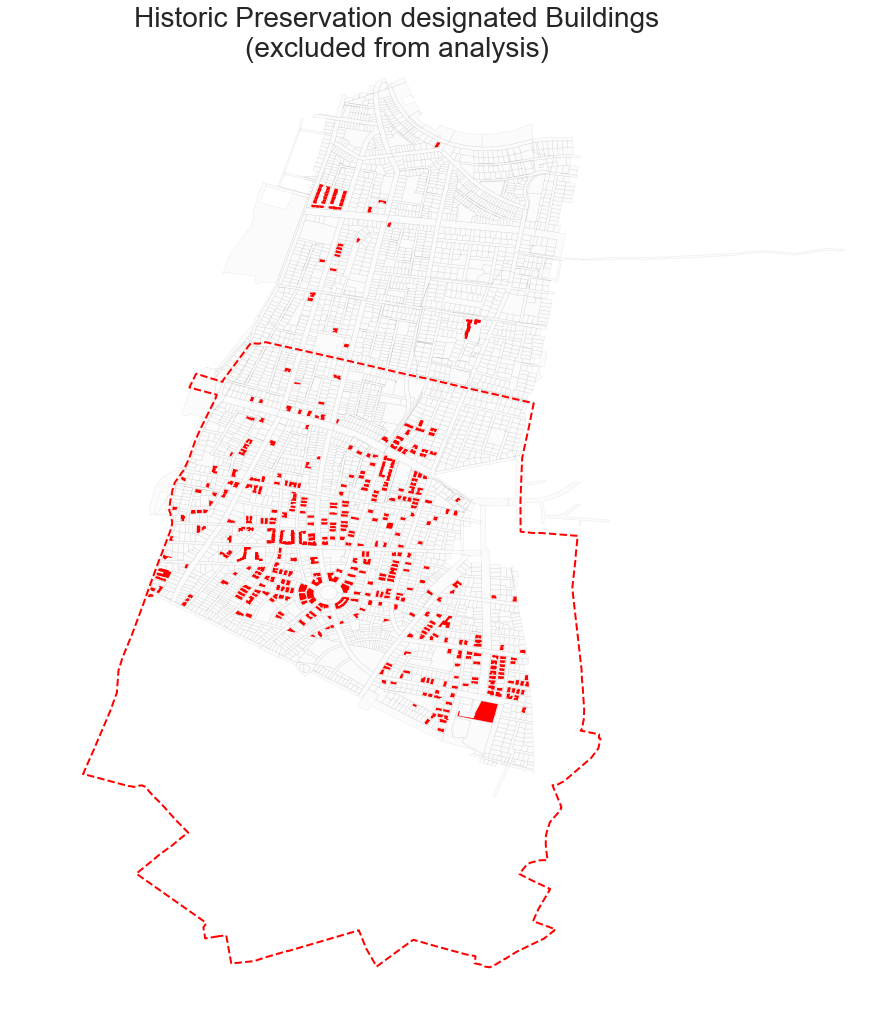

In [78]:
fig = pl.figure(figsize=(15,18))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.5, alpha=0.08)
HistoricOUT.plot(ax=ax, color='red', edgecolor=None);
HistoricIN.plot(ax=ax, color='red', edgecolor=None);
gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)

plt.title('Historic Preservation designated Buildings\n(excluded from analysis)', size=28, y=.97, x=0.42)
tmp = ax.axis('off')

### Fig.2 Historic Preservation designated Buildings, Precinct no.3 Tel-Aviv City
These buildings have different zoning and thus were excluded from this analysis. It can be seen that within the Whitw City zone there are much more designated for preservation buildings than outside of it.

In [79]:
# % of preservation buildings in and out

print('Within the "White City" zone the are {} buildings designated for preservation, '
      'out of {} buildings in the area, {:.2f}% of total buildings'
      .format(len(HistoricIN), len(buildingsshpIN), len(HistoricIN)/len(buildingsshpIN)*100))

Within the "White City" zone the are 436 buildings designated for preservation, out of 2563 buildings in the area, 17.01% of total buildings


In [80]:
print('Outside the "White City" zone the are {} buildings designated for preservation, '
      'out of {} buildings in the area, {:.2f}% of total buildings'
      .format(len(HistoricOUT), len(buildingsshpOUT), len(HistoricOUT)/len(buildingsshpOUT)*100))

Outside the "White City" zone the are 45 buildings designated for preservation, out of 1650 buildings in the area, 2.73% of total buildings


## Joining Addresses + Historic preservation in order to remove historic buildings

In [81]:
AddressesIN = AddressesIN.merge(HistoricIN, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesIN = AddressesIN[AddressesIN['thatraa'] == 0]
AddressesIN = AddressesIN.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesIN.shape

(2600, 9)

In [82]:
AddressesIN.head(3)

idAddress  oldidAddress streetName       Address       AddressX  \
0    75906.0       75906.0      הפרדס       הפרדס 9  179454.431532   
1    74570.0       74570.0  בן גוריון  בן גוריון 59  178937.908125   
2    69885.0       69885.0      רופין      רופין 45  178556.837843   

        AddressY        lon        lat              BBL  
0  665746.201281  34.780725  32.084308  (6215.0, 294.0)  
1  665746.201281  34.775254  32.084291   (6954.0, 98.0)  
2  665746.154375  34.771218  32.084277   (6968.0, 68.0)

In [83]:
AddressesOUT = AddressesOUT.merge(HistoricOUT, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesOUT = AddressesOUT[AddressesOUT['thatraa'] == 0]
AddressesOUT = AddressesOUT.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesOUT.shape

(1849, 9)

In [84]:
AddressesOUT.head(3)

idAddress  oldidAddress streetName      Address       AddressX  \
0    75400.0       75400.0       מיכה      מיכה 15  178988.400358   
1    73105.0       73105.0    דיזנגוף  דיזנגוף 294  179091.845656   
2    74069.0       74069.0    סוקולוב   סוקולוב 97  179242.033110   

       AddressY        lon        lat             BBL  
0  666805.23250  34.775744  32.093842  (6961.0, 67.0)  
1  666804.82625  34.776840  32.093842  (6959.0, 77.0)  
2  666803.56064  34.778431  32.093836  (6959.0, 40.0)

# Joining shp to have Buildings + Parcels data for each observation
### White City Zone

In [85]:
PCT3shpIN = parcelsshpIN.merge(AddressesIN, on = 'BBL')
PCT3shpIN.head()

idParcel  ParcelArea                                           geometry  \
0    2079.0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1    2081.0       284.0  POLYGON ((34.77344341891495 32.08711095658551,...   
2    2081.0       284.0  POLYGON ((34.77344341891495 32.08711095658551,...   
3    3208.0       281.0  POLYGON ((34.77303315814694 32.08714497353659,...   
4    3209.0       518.0  POLYGON ((34.77120851853805 32.08690002717208,...   

               BBL  idAddress  oldidAddress       streetName  \
0  (6902.0, 241.0)    76317.0       76317.0  ברנשטיין אדוארד   
1  (6902.0, 116.0)    73537.0       73537.0        ארלוזורוב   
2  (6902.0, 116.0)    65865.0       65865.0         בן יהודה   
3   (6902.0, 59.0)    65834.0       65834.0         בן יהודה   
4   (6966.0, 20.0)    66281.0       66281.0           הירקון   

              Address       AddressX       AddressY        lon        lat  
0  ברנשטיין אדוארד 26  178681.048750  666071.357485  34.772520  32.087214  
1        ארלוזורוב 16  178763.595656  666063.263750  34.773394  32.087144  
2        בן יהודה 172  178753.814406  666062.545031  34.773291  32.087137  
3        בן יהודה 141  178721.853437  666058.482546  34.772952  32.087099  
4          הירקון 186  178553.064406  666058.013765  34.771164  32.087089

In [86]:
PCT3shpIN.shape

(2600, 12)

In [87]:
PCT3shpIN = PCT3shpIN.merge(buildingsshpIN, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpIN = PCT3shpIN.drop(['idConst', 'idBuilding','idAddress', 'Address', 'oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpIN.head()

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       284.0  POLYGON ((34.77344341891495 32.08711095658551,...   
2       281.0  POLYGON ((34.77303315814694 32.08714497353659,...   
3       518.0  POLYGON ((34.77120851853805 32.08690002717208,...   
4       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   

               BBL       streetName       AddressX       AddressY        lon  \
0  (6902.0, 241.0)  ברנשטיין אדוארד  178681.048750  666071.357485  34.772520   
1  (6902.0, 116.0)         בן יהודה  178753.814406  666062.545031  34.773291   
2   (6902.0, 59.0)         בן יהודה  178721.853437  666058.482546  34.772952   
3   (6966.0, 20.0)           הירקון  178553.064406  666058.013765  34.771164   
4  (6951.0, 111.0)          השופטים  179488.994062  664838.560656  34.781129   

         lat BuildingType  Floors   footprint  height  
0  32.087214    מבנה רגיל     3.0  154.417758    17.0  
1  32.087137    מבנה רגיל     5.0  144.052006    22.0  
2  32.087099    מבנה רגיל     5.0  158.177808    22.0  
3  32.087089    מבנה רגיל     4.0  247.139010    18.0  
4  32.076125    מבנה רגיל     4.0  252.530801    16.0

In [88]:
PCT3shpIN.shape

(1642, 12)

In [89]:
type(PCT3shpIN)

geopandas.geodataframe.GeoDataFrame

### outside White City Zone

In [90]:
PCT3shpOUT = parcelsshpOUT.merge(AddressesOUT, on = 'BBL')
PCT3shpOUT.head()

idParcel  ParcelArea                                           geometry  \
0     467.0       282.0  POLYGON ((34.77856318885686 32.09408597755429,...   
1     469.0       275.0  POLYGON ((34.77912810593715 32.09412141266468,...   
2     471.0       417.0  POLYGON ((34.77570836899265 32.0941418815794, ...   
3     480.0       325.0  POLYGON ((34.77745222818285 32.09287050036341,...   
4     523.0       553.0  POLYGON ((34.78063465594656 32.09392296441273,...   

               BBL  idAddress  oldidAddress     streetName           Address  \
0   (6959.0, 32.0)    74071.0       74071.0        סוקולוב       סוקולוב 101   
1    (6957.0, 5.0)    74701.0       74701.0         ישעיהו         ישעיהו 12   
2  (6961.0, 106.0)    75404.0       75404.0           מיכה           מיכה 19   
3  (6959.0, 108.0)    74955.0       74955.0          מלאכי          מלאכי 14   
4   (6958.0, 34.0)    74760.0       74760.0  יוחנן הורקנוס  יוחנן הורקנוס 11   

        AddressX       AddressY        lon        lat  
0  179249.556608  666838.013735  34.778509  32.094147  
1  179300.251875  666835.216860  34.779047  32.094123  
2  178975.822157  666836.638796  34.775610  32.094125  
3  179141.806578  666693.248156  34.777374  32.092838  
4  179451.892531  666819.029375  34.780654  32.093983

In [91]:
PCT3shpOUT.shape

(1849, 12)

In [92]:
PCT3shpOUT = PCT3shpOUT.merge(buildingsshpOUT, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpOUT = PCT3shpOUT.drop(['idConst', 'idBuilding','idAddress', 'Address','oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpOUT.head()

ParcelArea                                           geometry  \
0       275.0  POLYGON ((34.77912810593715 32.09412141266468,...   
1       417.0  POLYGON ((34.77570836899265 32.0941418815794, ...   
2       325.0  POLYGON ((34.77745222818285 32.09287050036341,...   
3       553.0  POLYGON ((34.78063465594656 32.09392296441273,...   
4       533.0  POLYGON ((34.7804767984501 32.09392660250479, ...   

               BBL     streetName       AddressX       AddressY        lon  \
0    (6957.0, 5.0)         ישעיהו  179300.251875  666835.216860  34.779047   
1  (6961.0, 106.0)           מיכה  178975.822157  666836.638796  34.775610   
2  (6959.0, 108.0)          מלאכי  179141.806578  666693.248156  34.777374   
3   (6958.0, 34.0)  יוחנן הורקנוס  179451.892531  666819.029375  34.780654   
4  (6958.0, 123.0)  יוחנן הורקנוס  179434.376860  666817.998110  34.780468   

         lat BuildingType  Floors   footprint  height  
0  32.094123    מבנה רגיל     4.0  117.242392    13.0  
1  32.094125    מבנה רגיל     4.0  208.665958    18.0  
2  32.092838    מבנה רגיל     4.0  155.031697    17.0  
3  32.093983    מבנה רגיל     3.0  303.026016    13.0  
4  32.093973    מבנה רגיל     4.0  276.398086    22.0

In [93]:
PCT3shpOUT.shape

(1176, 12)

In [94]:
type(PCT3shpOUT)

geopandas.geodataframe.GeoDataFrame

# Data cleaning and munging
### White City Zone

In [95]:
# dropping non-residential buildings
PCT3shpIN = (PCT3shpIN[PCT3shpIN['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpIN = PCT3shpIN.drop(['index', 'BuildingType'], axis=1)
print(PCT3shpIN.shape)

# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] <= 4.0])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] >= 3.0])
print(PCT3shpIN.shape)

# dropping area > 1250 m2
PCT3shpIN = (PCT3shpIN[PCT3shpIN['ParcelArea'] <= 1250])

# assuming 4 housing units in a storey
PCT3shpIN['hUnits'] = PCT3shpIN['Floors'] * 4

# Calculating Floor Area (Floors * ShapeArea)
PCT3shpIN['FloorArea'] = PCT3shpIN['Floors'] * PCT3shpIN['footprint']

# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpIN['FAR'] = PCT3shpIN['FloorArea'] / PCT3shpIN['ParcelArea']
PCT3shpIN = (PCT3shpIN[PCT3shpIN['FAR'] <= 4.25])

#White city zone == 1
PCT3shpIN['WhiteCity'] = 1

PCT3shpIN.head()

(1616, 11)
(1316, 11)


ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
3       518.0  POLYGON ((34.77120851853805 32.08690002717208,...   
4       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
5       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   
8       360.0  POLYGON ((34.77120676544948 32.07850701386839,...   

               BBL       streetName       AddressX       AddressY        lon  \
0  (6902.0, 241.0)  ברנשטיין אדוארד  178681.048750  666071.357485  34.772520   
3   (6966.0, 20.0)           הירקון  178553.064406  666058.013765  34.771164   
4  (6951.0, 111.0)          השופטים  179488.994062  664838.560656  34.781129   
5  (7091.0, 192.0)           פינסקר  178653.783140  664841.779406  34.772283   
8   (6906.0, 81.0)       שלום עליכם  178535.861235  665120.513781  34.771022   

         lat  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  32.087214     3.0  154.417758    17.0    12.0   463.253274  1.690705   
3  32.087089     4.0  247.139010    18.0    16.0   988.556038  1.908409   
4  32.076125     4.0  252.530801    16.0    16.0  1010.123204  1.965220   
5  32.076125     4.0  171.562549    14.0    16.0   686.250196  1.994913   
8  32.078635     4.0  150.359237    19.0    16.0   601.436948  1.670658   

   WhiteCity  
0          1  
3          1  
4          1  
5          1  
8          1

In [96]:
PCT3shpIN.shape

(1307, 15)

In [97]:
PCT3shpIN.hUnits.sum()

18328.0

### outside White City Zone

In [98]:
# dropping non-residential buildings
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpOUT = PCT3shpOUT.drop(['index', 'BuildingType'], axis=1)
print(PCT3shpOUT.shape)

# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] <= 4.0])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] >= 3.0])
print(PCT3shpOUT.shape)

# dropping area > 1250 m2
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['ParcelArea'] <= 1250])

# assuming 4 housing units in a storey
PCT3shpOUT['hUnits'] = PCT3shpOUT['Floors'] * 4

# Calculating Floor Area (Floors * ShapeArea)
PCT3shpOUT['FloorArea'] = PCT3shpOUT['Floors'] * PCT3shpOUT['footprint']

# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpOUT['FAR'] = PCT3shpOUT['FloorArea'] / PCT3shpOUT['ParcelArea']
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['FAR'] <= 4.25])

#White city zone == 0
PCT3shpOUT['WhiteCity'] = 0

PCT3shpOUT.head()

(1149, 11)
(891, 11)


ParcelArea                                           geometry  \
0       275.0  POLYGON ((34.77912810593715 32.09412141266468,...   
1       417.0  POLYGON ((34.77570836899265 32.0941418815794, ...   
2       325.0  POLYGON ((34.77745222818285 32.09287050036341,...   
3       553.0  POLYGON ((34.78063465594656 32.09392296441273,...   
4       533.0  POLYGON ((34.7804767984501 32.09392660250479, ...   

               BBL     streetName       AddressX       AddressY        lon  \
0    (6957.0, 5.0)         ישעיהו  179300.251875  666835.216860  34.779047   
1  (6961.0, 106.0)           מיכה  178975.822157  666836.638796  34.775610   
2  (6959.0, 108.0)          מלאכי  179141.806578  666693.248156  34.777374   
3   (6958.0, 34.0)  יוחנן הורקנוס  179451.892531  666819.029375  34.780654   
4  (6958.0, 123.0)  יוחנן הורקנוס  179434.376860  666817.998110  34.780468   

         lat  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  32.094123     4.0  117.242392    13.0    16.0   468.969568  1.705344   
1  32.094125     4.0  208.665958    18.0    16.0   834.663832  2.001592   
2  32.092838     4.0  155.031697    17.0    16.0   620.126790  1.908082   
3  32.093983     3.0  303.026016    13.0    12.0   909.078048  1.643902   
4  32.093973     4.0  276.398086    22.0    16.0  1105.592344  2.074282   

   WhiteCity  
0          0  
1          0  
2          0  
3          0  
4          0

#### PCT3shpOUT.shape

In [99]:
PCT3shpOUT.hUnits.sum()

12488.0

In [100]:
PCT3shp = [PCT3shpIN, PCT3shpOUT]
PCT3shp = pd.concat(PCT3shp)

PCT3shp['footprintPerc'] = PCT3shp['footprint']/(PCT3shp['ParcelArea'])*100
PCT3shp = PCT3shp[PCT3shp['footprintPerc'] < 100]

PCT3shp.shape

(2161, 16)

In [101]:
type(PCT3shp)

geopandas.geodataframe.GeoDataFrame

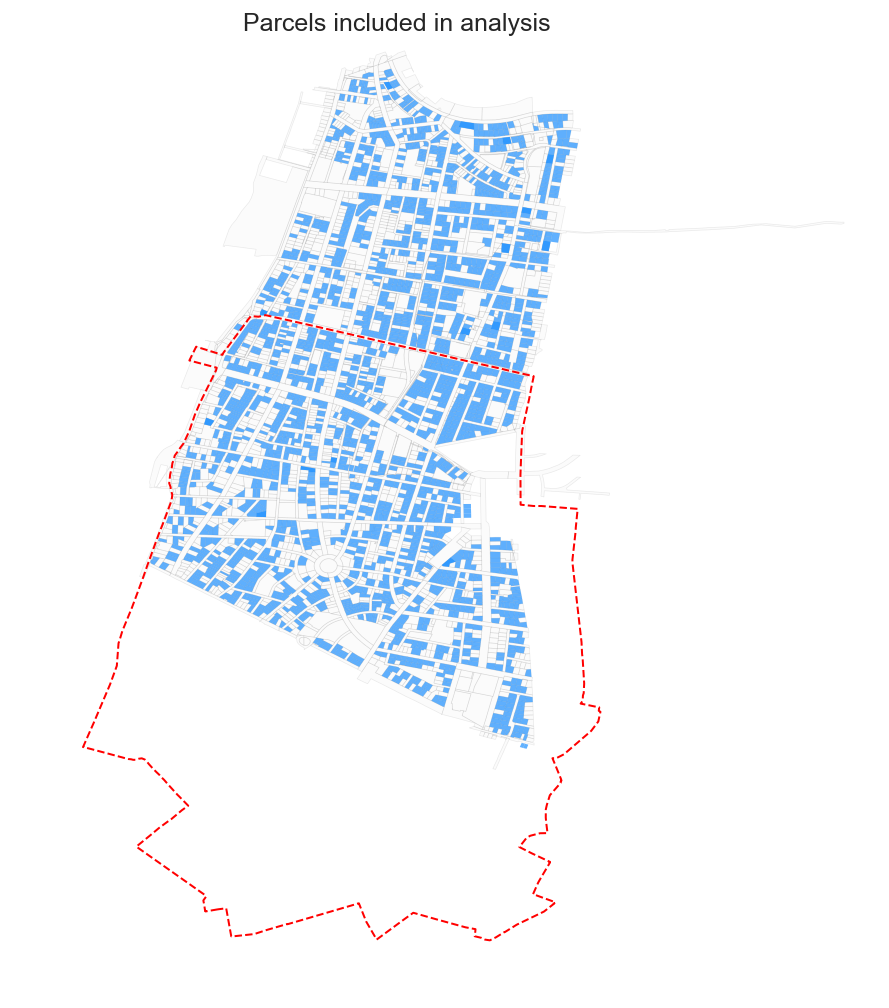

In [102]:
fig = pl.figure(figsize=(15,18))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp.plot(ax=ax, color='dodgerblue', edgecolor=None, alpha=0.7);

gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)

plt.title('Parcels included in analysis', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

### Fig.3 Parcels included in the analysis
In this analysis **2161 parcels** were included. **1307 parcels**, about **60%**, are within the White Coty Zone and **856 parcels** are outsode of it.

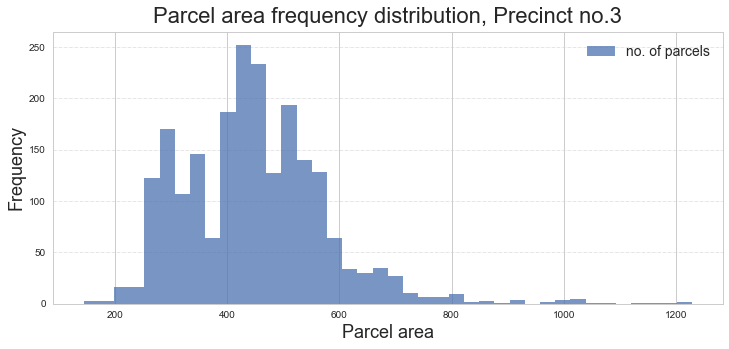

In [103]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

PCT3shp['ParcelArea'].plot(kind="hist", bins=40, label='no. of parcels', alpha=0.75)

ax.set_title("Parcel area frequency distribution, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("Parcel area", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.5, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

-----

# FAR distribution precinct 3 -- current

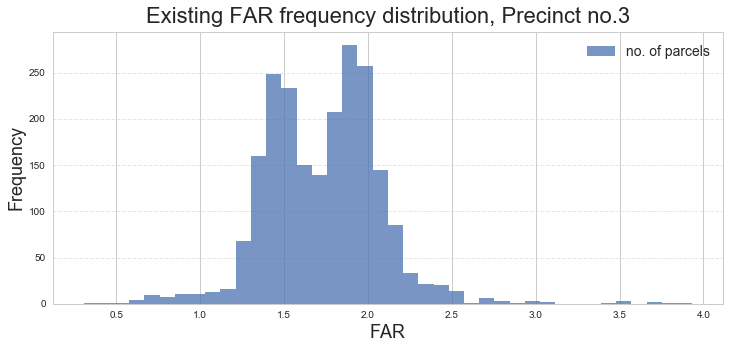

In [104]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

PCT3shp['FAR'].plot(kind="hist", bins=40, label='no. of parcels', alpha=0.75)

ax.set_title("Existing FAR frequency distribution, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("FAR", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.5, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

### Fig.4 histogram of current FAR of parcels in precinct 3, Tel-Aviv
Most parcels have FAR arount 2 (meaning 200% floor area is built out of parcel's area). Between 1.03 and 2 FAR are a lot of parcels as well. A little amount of parcels are built with FAR higher than 2.0.

# Plot a map of Floor Area for precinct 3

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


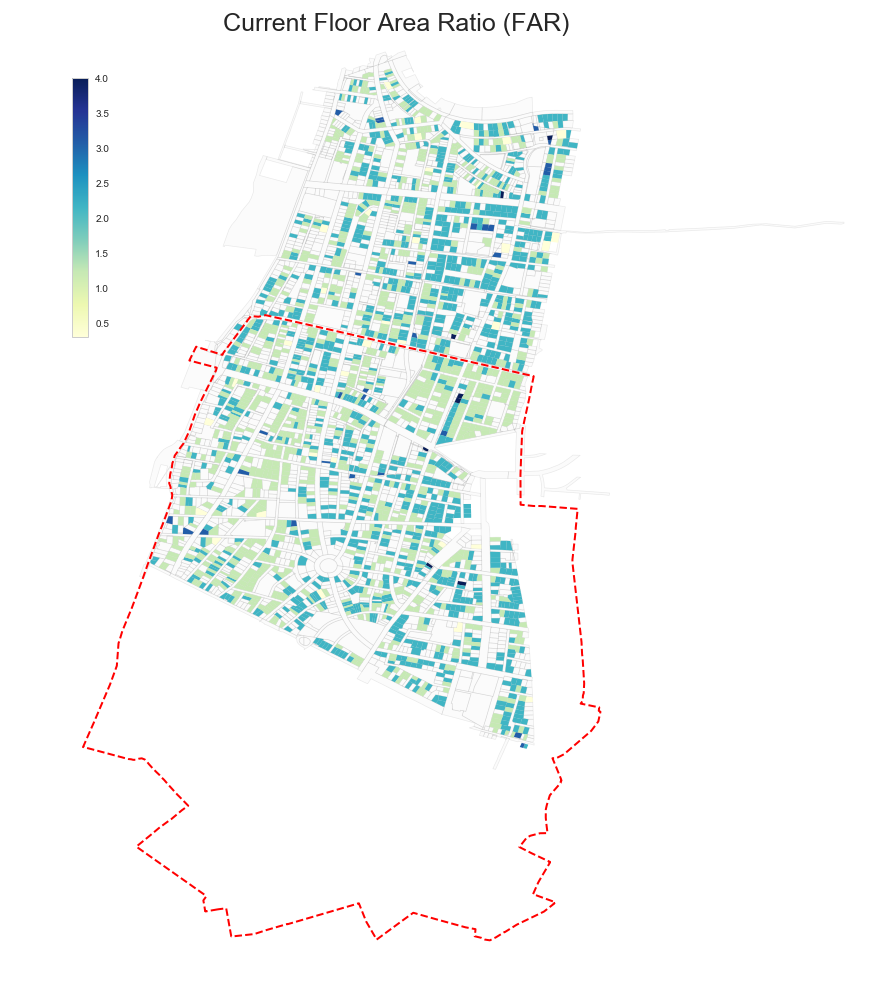

In [105]:
fig = pl.figure(figsize=(15,18))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp.plot(ax=ax, column='FAR', cmap='YlGnBu', scheme='Equal_Interval', label='FAR');
plt.title('Current Floor Area Ratio (FAR)', size=25, y=.97, x=0.42)

gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)

vmin, vmax = 0.3, 4.0

cax = fig.add_axes([0.15, 0.625, .015, 0.2])
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')

tmp = ax.axis('off')
plt.legend(fontsize=14)
plt.show()

### Fig.4 Current Floor-Area Ratio (FAR) 
The majority of the buildings' FAR is ranged between **1.07 - 2.2**

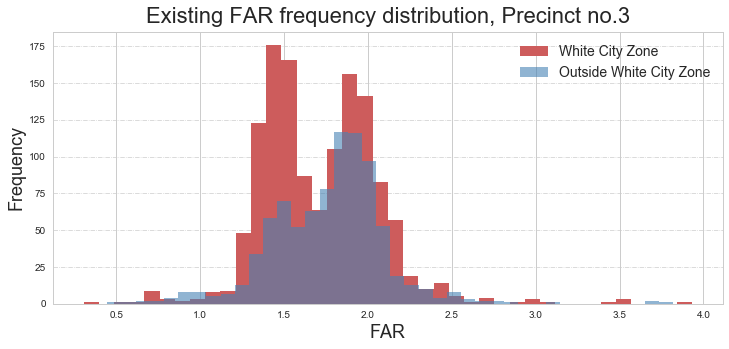

In [106]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

(PCT3shp['FAR'][PCT3shp['WhiteCity'] == 1]).plot(kind="hist", color='IndianRed',
                                            bins=40, label='White City Zone')
ax = (PCT3shp['FAR'][PCT3shp['WhiteCity'] == 0]).plot(kind="hist", color='steelBlue',
                             bins=40, label='Outside White City Zone', alpha=0.6)


ax.set_title("Existing FAR frequency distribution, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("FAR", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

### Fig.4 histogram of current FAR of parcels in precinct 3, Tel-Aviv, within and outside the "White City" zone
Most parcels have FAR arount 2 (meaning 200% floor area is built out of parcel's area). Between 1.03 and 2 FAR are a lot of parcels as well. A little amount of parcels are built with FAR higher than 2.0.

### Check whether the FAR distribution follow a Gaussian
Using AD statistical test:

In [107]:
import scipy as sp

# statistical significance threshold
alpha = 0.05

adFAR = sp.stats.anderson((PCT3shp.FAR - 
                PCT3shp.FAR.mean())  / 
                    PCT3shp.FAR.std(), "norm")
verb = "does not " if adFAR[0] > adFAR[1][adFAR[2] == alpha * 100] else "does "
print ("The distribution of FAR " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of FAR does not follow a normal distribution (p < 0.05) according to the AD test


In [108]:
# foot print %

adfootprint = sp.stats.anderson((PCT3shp.footprintPerc - 
                PCT3shp.footprintPerc.mean())  / 
                    PCT3shp.footprintPerc.std(), "norm")
verb = "does not " if adfootprint[0] > adfootprint[1][adfootprint[2] == alpha * 100] else "does "
print ("The distribution of FAR " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of FAR does not follow a normal distribution (p < 0.05) according to the AD test


---
## Defining commercial streets 
Commercial streets have different development limitations according to the ordinance and thus should be calculated separately. 
- Inside White City Zone: **Dizengof, Ben-Yehuda, Arlozorov, Hayarkon** streets
- Outside White City Zone: **Dizengof, Ben-Yehuda** streets

In [109]:
commerceIN = [PCT3shpIN[PCT3shpIN['streetName']  == 'דיזנגוף'], PCT3shpIN[PCT3shpIN['streetName']  == 'בן יהודה'], 
              PCT3shpIN[PCT3shpIN['streetName']  == 'ארלוזורוב'], PCT3shpIN[PCT3shpIN['streetName']  == 'הירקון']]
commerceIN = pd.concat(commerceIN).reset_index()
commerceIN = commerceIN.drop(['index', 'streetName'], axis=1)
commerceIN['commerce'] = 1

# density coefition >> to later calculation of new no. of housing units
commerceIN['denscoef'] = 65

commerceIN.head(3)

ParcelArea                                           geometry  \
0       306.0  POLYGON ((34.77406439592887 32.08376795464817,...   
1       434.0  POLYGON ((34.77371048563466 32.08158037063139,...   
2       554.0  POLYGON ((34.77452953052502 32.08566399724136,...   

               BBL       AddressX       AddressY        lon        lat  \
0  (7078.0, 116.0)  178816.173765  665691.591844  34.773967  32.083794   
1   (7113.0, 55.0)  178775.923750  665441.716936  34.773551  32.081539   
2  (6902.0, 158.0)  178863.126875  665903.669985  34.774455  32.085708   

   Floors   footprint  height  hUnits   FloorArea       FAR  WhiteCity  \
0     3.0  134.125293    15.0    12.0  402.375878  1.314954          1   
1     3.0  222.888763    18.0    12.0  668.666289  1.540706          1   
2     3.0  309.996586    13.0    12.0  929.989758  1.678682          1   

   commerce  denscoef  
0         1        65  
1         1        65  
2         1        65

In [110]:
commerceIN.shape

(156, 16)

In [111]:
commerceOUT = [PCT3shpOUT[PCT3shpOUT['streetName']  == 'דיזנגוף'], PCT3shpOUT[PCT3shpOUT['streetName']  == 'בן יהודה']]
commerceOUT = pd.concat(commerceOUT).reset_index()
commerceOUT = commerceOUT.drop(['index', 'streetName'], axis=1)
commerceOUT['commerce'] = 1

# density coefition >> to later calculation of new no. of housing units
commerceOUT['denscoef'] = 65

commerceOUT.head(3)

ParcelArea                                           geometry  \
0       283.0  POLYGON ((34.77626542263859 32.0959676525227, ...   
1       458.0  POLYGON ((34.77638620981109 32.09411838256487,...   
2       350.0  POLYGON ((34.77709255079024 32.09395967222037,...   

              BBL       AddressX       AddressY        lon        lat  Floors  \
0   (6963.0, 9.0)  179038.103437  667047.076281  34.776261  32.096025     4.0   
1  (6961.0, 58.0)  179066.931547  666844.326250  34.776575  32.094198     3.0   
2  (6959.0, 76.0)  179094.392500  666821.373140  34.776866  32.093992     3.0   

    footprint  height  hUnits   FloorArea       FAR  WhiteCity  commerce  \
0  133.578753    20.0    16.0  534.315012  1.888039          0         1   
1  220.570635    17.0    12.0  661.711904  1.444786          0         1   
2  157.218641    16.0    12.0  471.655924  1.347588          0         1   

   denscoef  
0        65  
1        65  
2        65

In [112]:
commerceOUT.shape

(76, 16)

In [113]:
# dropping commerce from PCT3IN 

PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'דיזנגוף'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'בן יהודה']) 
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'ארלוזורוב'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'הירקון']).reset_index()

PCT3shpIN['commerce'] = 0

# density coefition >> to later calculation of new no. of housing units
PCT3shpIN['denscoef'] = 80

PCT3shpIN = PCT3shpIN.drop(['index', 'streetName'], axis=1)
PCT3shpIN.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL       AddressX       AddressY        lon        lat  \
0  (6902.0, 241.0)  178681.048750  666071.357485  34.772520  32.087214   
1  (6951.0, 111.0)  179488.994062  664838.560656  34.781129  32.076125   
2  (7091.0, 192.0)  178653.783140  664841.779406  34.772283  32.076125   

   Floors   footprint  height  hUnits    FloorArea       FAR  WhiteCity  \
0     3.0  154.417758    17.0    12.0   463.253274  1.690705          1   
1     4.0  252.530801    16.0    16.0  1010.123204  1.965220          1   
2     4.0  171.562549    14.0    16.0   686.250196  1.994913          1   

   commerce  denscoef  
0         0        80  
1         0        80  
2         0        80

In [114]:
PCT3shpIN.shape

(1151, 16)

In [115]:
# dropping commerce from PCT3OUT

PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'דיזנגוף'])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'בן יהודה']).reset_index()

PCT3shpOUT['commerce'] = 0

# density coefition >> to later calculation of new no. of housing units
PCT3shpOUT['denscoef'] = 80

PCT3shpOUT = PCT3shpOUT.drop(['index', 'streetName'], axis=1)
PCT3shpOUT.head(3)

ParcelArea                                           geometry  \
0       275.0  POLYGON ((34.77912810593715 32.09412141266468,...   
1       417.0  POLYGON ((34.77570836899265 32.0941418815794, ...   
2       325.0  POLYGON ((34.77745222818285 32.09287050036341,...   

               BBL       AddressX       AddressY        lon        lat  \
0    (6957.0, 5.0)  179300.251875  666835.216860  34.779047  32.094123   
1  (6961.0, 106.0)  178975.822157  666836.638796  34.775610  32.094125   
2  (6959.0, 108.0)  179141.806578  666693.248156  34.777374  32.092838   

   Floors   footprint  height  hUnits   FloorArea       FAR  WhiteCity  \
0     4.0  117.242392    13.0    16.0  468.969568  1.705344          0   
1     4.0  208.665958    18.0    16.0  834.663832  2.001592          0   
2     4.0  155.031697    17.0    16.0  620.126790  1.908082          0   

   commerce  denscoef  
0         0        80  
1         0        80  
2         0        80

In [116]:
PCT3shpOUT.shape

(780, 16)

---
# Calculating new rezoning parameters: anticipated FA,  anticipated FAR, Floors

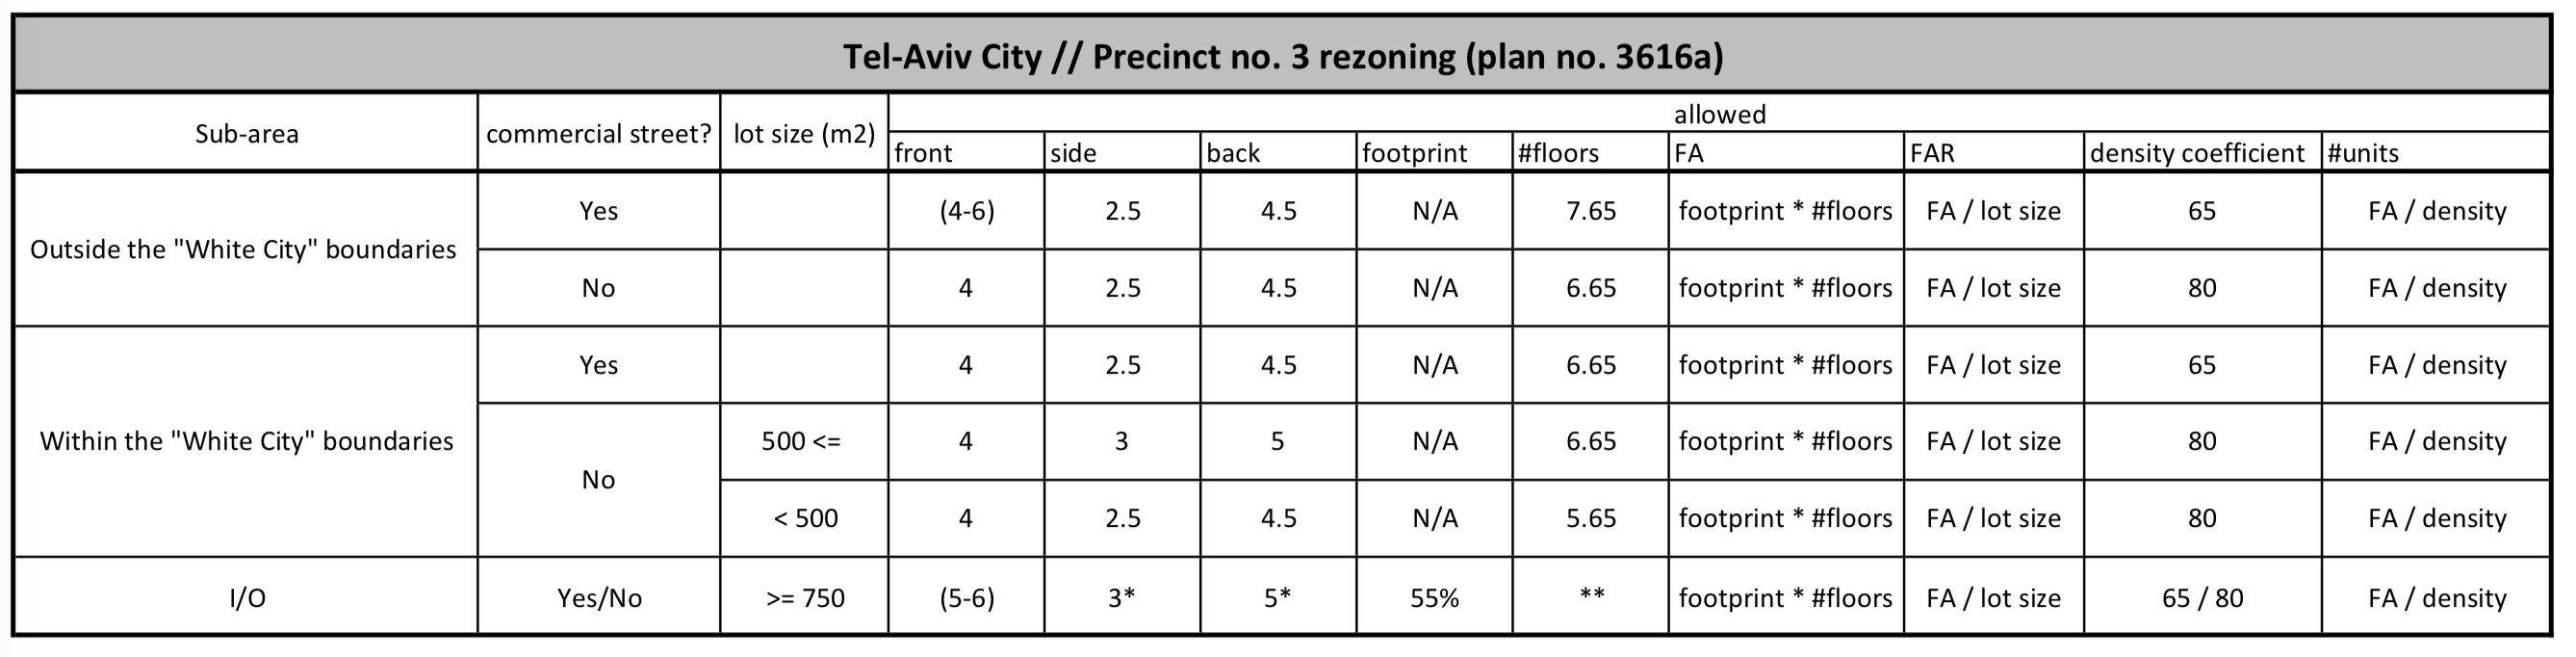

In [117]:
# Rezoning Precinct3 table

from IPython.display import Image
Image('Precinct3ordinance.png')

### Table.1 Precinct no. 3 rezoning guidlines
The ordinance diffrentiates between parcels _within the White City zone_ and _outside of it_, allowing **one additional story** outside the historical site (0.65 story is due to additional setbacks required for the highest floor).  **Setbacks** from parcel’s boundaries determine the allowed footprint and are more rigidly limited for very small parcels (_500m2 or smaller_) inside the White City zone. For parcels of _750m2 or more_, the **footprint is limites to 55%** within these setbacks. Also, **density coefficiet**, a proxy for the average size of unit and according to which the number of housing units allowed in a parcel is calculated, is smaller in commercial streets than in non-commercial ones, allowing _more and smaller units in main roads_. 


## Assessing allowed footprint

The ordinance defines required setbacks (front, side and back) for parcels smaller than 750m2. The outcome footprint for these parcels usually ranges between 42%-56% of the parcel’s area, appearing almost random. Thus, for this analysis, **footprints percentages of parcels smaller than 750m2 were randomly chosen between this range**.
For parcels equal to or larger than 750m2, a maximum footprint of 55% of the parcel’s area is required, within the setbacks boundaries.

In [118]:
## import random
random.seed(777)

In [119]:
# creating random footprint for further calculation >> assuming footprint between 42% - 55%

PCT3shpIN['randFootprint'] = np.random.uniform(0.44, 0.56, size = len(PCT3shpIN))
PCT3shpOUT['randFootprint'] = np.random.uniform(0.44, 0.56, size = len(PCT3shpOUT))
commerceIN['randFootprint'] = np.random.uniform(0.44, 0.56, size = len(commerceIN))
commerceOUT['randFootprint'] = np.random.uniform(0.44, 0.56, size = len(commerceOUT))

PCT3shpIN.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL       AddressX       AddressY        lon        lat  \
0  (6902.0, 241.0)  178681.048750  666071.357485  34.772520  32.087214   
1  (6951.0, 111.0)  179488.994062  664838.560656  34.781129  32.076125   
2  (7091.0, 192.0)  178653.783140  664841.779406  34.772283  32.076125   

   Floors   footprint  height  hUnits    FloorArea       FAR  WhiteCity  \
0     3.0  154.417758    17.0    12.0   463.253274  1.690705          1   
1     4.0  252.530801    16.0    16.0  1010.123204  1.965220          1   
2     4.0  171.562549    14.0    16.0   686.250196  1.994913          1   

   commerce  denscoef  randFootprint  
0         0        80       0.458320  
1         0        80       0.476283  
2         0        80       0.447444

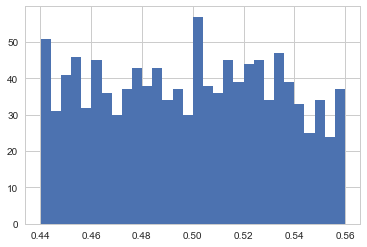

In [120]:
PCT3shpIN['randFootprint'].hist(bins=30)

In [121]:
# new footprint (random between 0.4 and 0.55 footprint for small parcels)
PCT3shpIN['footprint_new'] = np.where(PCT3shpIN['ParcelArea'] >= 750, PCT3shpIN['ParcelArea'] * 0.55,
                                      PCT3shpIN['ParcelArea'] * PCT3shpIN['randFootprint'])
PCT3shpOUT['footprint_new'] = np.where(PCT3shpOUT['ParcelArea'] >= 750, PCT3shpOUT['ParcelArea'] * 0.55,
                                       PCT3shpOUT['ParcelArea'] * PCT3shpOUT['randFootprint'])
commerceIN['footprint_new'] = np.where(commerceIN['ParcelArea'] >= 750, commerceIN['ParcelArea'] * 0.55, 
                                       commerceIN['ParcelArea'] * commerceIN['randFootprint'])
commerceOUT['footprint_new'] = np.where(commerceOUT['ParcelArea'] >= 750, commerceOUT['ParcelArea'] * 0.55, 
                                        commerceOUT['ParcelArea'] * commerceOUT['randFootprint'])

# new no. of floors 
PCT3shpIN['Floors_new'] = np.where(PCT3shpIN['ParcelArea'] < 500, 5.65, 6.65)
PCT3shpOUT['Floors_new'] = 6.65
commerceIN['Floors_new'] = 6.65
commerceOUT['Floors_new'] = 7.65

PCT3shpIN.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL       AddressX       AddressY        lon        lat  \
0  (6902.0, 241.0)  178681.048750  666071.357485  34.772520  32.087214   
1  (6951.0, 111.0)  179488.994062  664838.560656  34.781129  32.076125   
2  (7091.0, 192.0)  178653.783140  664841.779406  34.772283  32.076125   

   Floors   footprint  height  hUnits    FloorArea       FAR  WhiteCity  \
0     3.0  154.417758    17.0    12.0   463.253274  1.690705          1   
1     4.0  252.530801    16.0    16.0  1010.123204  1.965220          1   
2     4.0  171.562549    14.0    16.0   686.250196  1.994913          1   

   commerce  denscoef  randFootprint  footprint_new  Floors_new  
0         0        80       0.458320     125.579584        5.65  
1         0        80       0.476283     244.809356        6.65  
2         0        80       0.447444     153.920863        5.65

In [122]:
commerceOUT.head(2)

ParcelArea                                           geometry  \
0       283.0  POLYGON ((34.77626542263859 32.0959676525227, ...   
1       458.0  POLYGON ((34.77638620981109 32.09411838256487,...   

              BBL       AddressX       AddressY        lon        lat  Floors  \
0   (6963.0, 9.0)  179038.103437  667047.076281  34.776261  32.096025     4.0   
1  (6961.0, 58.0)  179066.931547  666844.326250  34.776575  32.094198     3.0   

    footprint  height  hUnits   FloorArea       FAR  WhiteCity  commerce  \
0  133.578753    20.0    16.0  534.315012  1.888039          0         1   
1  220.570635    17.0    12.0  661.711904  1.444786          0         1   

   denscoef  randFootprint  footprint_new  Floors_new  
0        65       0.503429     142.470447        7.65  
1        65       0.531004     243.199704        7.65

## Concat all df 

In [123]:
PCT3all = [PCT3shpIN, PCT3shpOUT, commerceIN, commerceOUT]
PCT3shp = pd.concat(PCT3all)
PCT3shp = PCT3shp.drop(['AddressX', 'AddressY', 'lon', 'lat'], axis=1)
PCT3shp.head()

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   
3       360.0  POLYGON ((34.77120676544948 32.07850701386839,...   
4       339.0  POLYGON ((34.77061162187506 32.07857072714503,...   

               BBL  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  (6902.0, 241.0)     3.0  154.417758    17.0    12.0   463.253274  1.690705   
1  (6951.0, 111.0)     4.0  252.530801    16.0    16.0  1010.123204  1.965220   
2  (7091.0, 192.0)     4.0  171.562549    14.0    16.0   686.250196  1.994913   
3   (6906.0, 81.0)     4.0  150.359237    19.0    16.0   601.436948  1.670658   
4   (6906.0, 92.0)     3.0  168.250159    16.0    12.0   504.750477  1.488939   

   WhiteCity  commerce  denscoef  randFootprint  footprint_new  Floors_new  
0          1         0        80       0.458320     125.579584        5.65  
1          1         0        80       0.476283     244.809356        6.65  
2          1         0        80       0.447444     153.920863        5.65  
3          1         0        80       0.495183     178.265967        5.65  
4          1         0        80       0.540230     183.138108        5.65

In [124]:
PCT3shp.shape

(2163, 15)

In [125]:
# anticipated floorarea 
PCT3shp['FA_new'] = PCT3shp['footprint_new'] * PCT3shp['Floors_new']

# anticipated FAR 
PCT3shp['FAR_new'] = PCT3shp['FA_new'] / PCT3shp['ParcelArea']

# anticipated housing units: FA_new / density coefition
PCT3shp['hUnits_new'] = ((PCT3shp['FA_new'] / PCT3shp['denscoef']) - 4).round()

PCT3shp.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  (6902.0, 241.0)     3.0  154.417758    17.0    12.0   463.253274  1.690705   
1  (6951.0, 111.0)     4.0  252.530801    16.0    16.0  1010.123204  1.965220   
2  (7091.0, 192.0)     4.0  171.562549    14.0    16.0   686.250196  1.994913   

   WhiteCity  commerce  denscoef  randFootprint  footprint_new  Floors_new  \
0          1         0        80       0.458320     125.579584        5.65   
1          1         0        80       0.476283     244.809356        6.65   
2          1         0        80       0.447444     153.920863        5.65   

        FA_new   FAR_new  hUnits_new  
0   709.524647  2.589506         5.0  
1  1627.982215  3.167281        16.0  
2   869.652877  2.528061         7.0

# FAR distribution precinct 3 -- all rezoning utilized

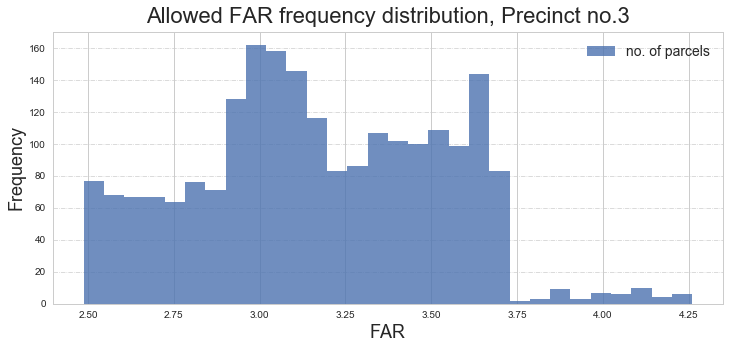

In [126]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

PCT3shp['FAR_new'].plot(kind="hist", bins=30, label='no. of parcels', alpha=0.8)

ax.set_title("Allowed FAR frequency distribution, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("FAR", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

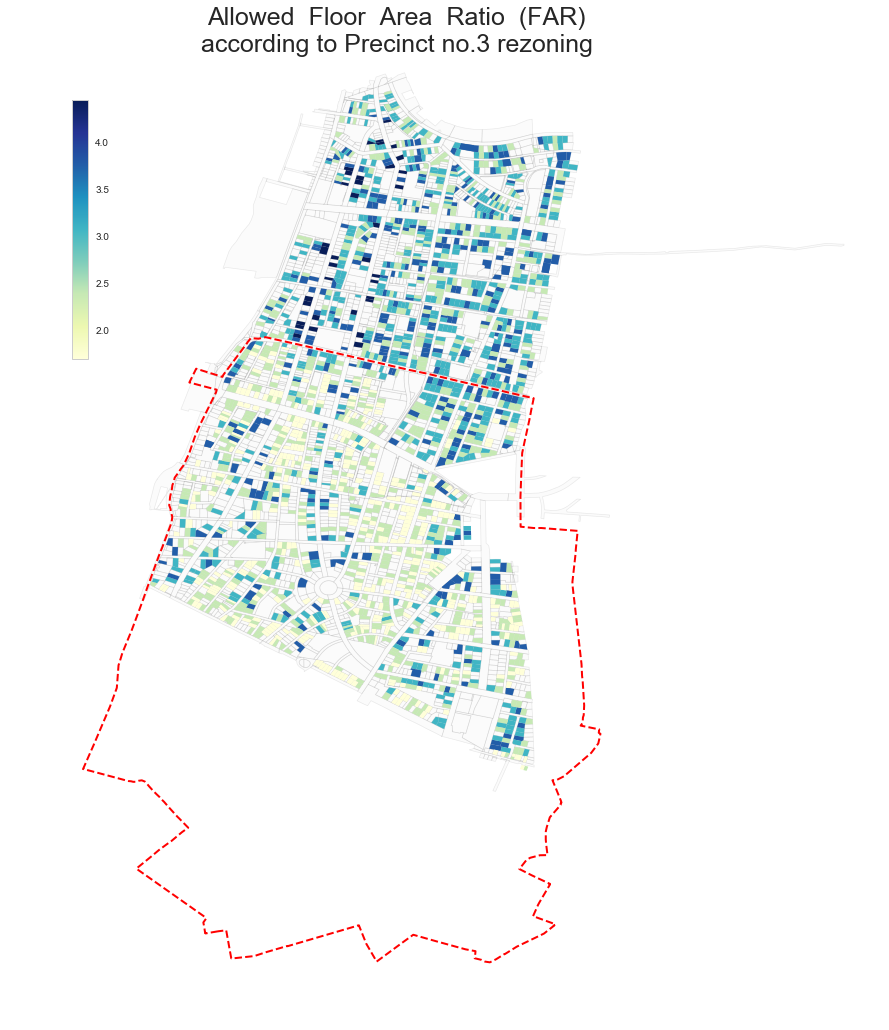

In [127]:
fig = pl.figure(figsize=(15,18))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp.plot(ax=ax, column='FAR_new', cmap='YlGnBu', scheme='Equal_Interval');
plt.title('Allowed  Floor  Area  Ratio  (FAR)\naccording to Precinct no.3 rezoning', size=25, y=.97, x=0.42)

gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)

vmin, vmax = 1.7, 4.45

cax = fig.add_axes([0.15, 0.625, .015, 0.2])
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')

tmp = ax.axis('off')

### Fig.5 Anticipated Floor-Area Ratio (FAR), if all Precinct no.3 rezoning utilized
The northern part of the precinct (outside the White City boundaries) has distinguishable higher FAR, although being far from the CBD (The centroid of Precinct no.5, south to Precinct no.3)

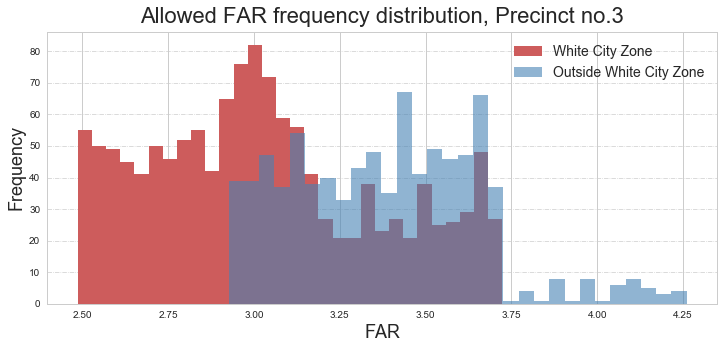

In [128]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

(PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 1]).plot(kind="hist",bins=30, color='IndianRed',
                                            label='White City Zone')
ax = (PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 0]).plot(kind="hist", bins=30, color='steelBlue',
                             label='Outside White City Zone', alpha=0.6)

ax.set_title("Allowed FAR frequency distribution, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("FAR", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)

plt.grid(linewidth=0.7, axis='y', linestyle='-.')

plt.legend(fontsize=14)
plt.show()

### Fig.6 Frequency distribution of allowed FAR, if rezoning fully utilized across the precinct
FAR outside the “White City” zone (blue) show higher results, while the “White City” zone (red) stays relatively closer to current FAR’s. Overall, FAR distribution is widening.

## ratio of current / allowed floor area

In [129]:
# Ratio current / anticipated floorarea 
PCT3shp['old/new_FA'] = PCT3shp['FloorArea'] / PCT3shp['FA_new'] 
PCT3shp.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  (6902.0, 241.0)     3.0  154.417758    17.0    12.0   463.253274  1.690705   
1  (6951.0, 111.0)     4.0  252.530801    16.0    16.0  1010.123204  1.965220   
2  (7091.0, 192.0)     4.0  171.562549    14.0    16.0   686.250196  1.994913   

   WhiteCity  commerce  denscoef  randFootprint  footprint_new  Floors_new  \
0          1         0        80       0.458320     125.579584        5.65   
1          1         0        80       0.476283     244.809356        6.65   
2          1         0        80       0.447444     153.920863        5.65   

        FA_new   FAR_new  hUnits_new  old/new_FA  
0   709.524647  2.589506         5.0    0.652907  
1  1627.982215  3.167281        16.0    0.620476  
2   869.652877  2.528061         7.0    0.789108

In [130]:
feasThreshold = [
    (PCT3shp['ParcelArea'] < 500) & (PCT3shp['old/new_FA'] <= 0.45),
    (PCT3shp['ParcelArea'] >= 750) & (PCT3shp['old/new_FA'] <= 0.55),
    (PCT3shp['ParcelArea'] >= 500) & (PCT3shp['ParcelArea'] < 750) & (PCT3shp['old/new_FA'] <= 0.5)]
choices = [1, 1, 1]
PCT3shp['Feasibility'] = np.select(feasThreshold, choices, default=0)
PCT3shp['Feasibility'].value_counts()

0    1653
1     510
Name: Feasibility, dtype: int64

In [131]:
(521 + 1642)

2163

## Only 521 parcels (24% of the parcels analysed) were found feasible for renewal according to the new rezoning ordinance, while 1642 (76% of the parcels analysed) were evaluated as not economically feasible.

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


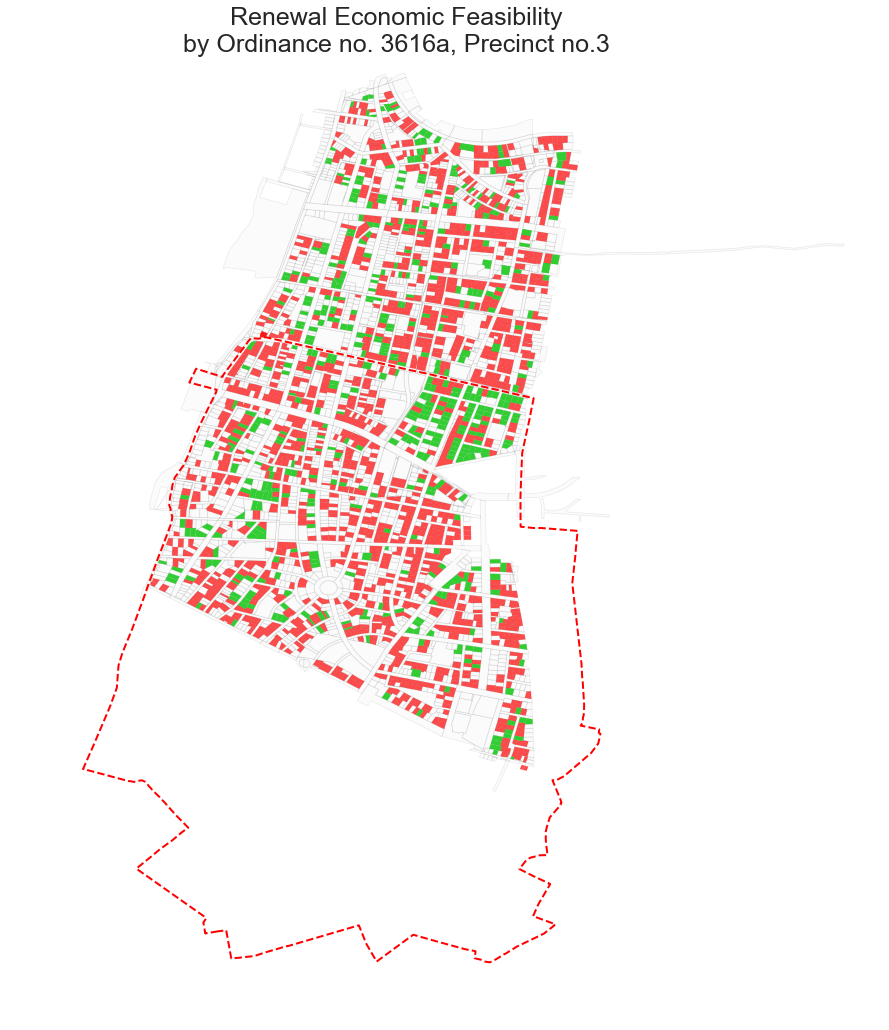

In [151]:
fig = pl.figure(figsize=(15,18))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp[PCT3shp['Feasibility'] == 1].plot(ax=ax, color='limegreen', edgecolor=None, label='Feasible')
PCT3shp[PCT3shp['Feasibility'] == 0].plot(ax=ax, color='red', edgecolor=None, label='Not Feasible', alpha=0.7)
gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)
# PCT3.plot(ax=ax, color='none', edgecolor='k', linewidth=1.5)

plt.title('Renewal Economic Feasibility\nby Ordinance no. 3616a, Precinct no.3', size=25, y=.97, x=0.42)
plt.legend(fontsize=14)
tmp = ax.axis('off')
plt.savefig("FeasibilityTLV.pdf", transparent=True)
plt.show()

### Fig.6 Economic Feasibility by parcel, rezoning Precinct no.3
Red parcels are **Not economic feasible** and will not be renewed according to this analysis, while the green parcels are **economic feasible** and are anticipated to be renewed thanks to the new rezoning ordinance. The share of the parcels were evaluated as feasible to renewal is only **25%** of the analysed parcels. Considering **471 historic preservation designated parcels** in the precinct, it appears that the rezoning, although allowing much more floor area, leaves **more than 75% of the precinct's buildings** not feasible enough for its utilization. 

In [133]:
PCT3shp.head(3)

ParcelArea                                           geometry  \
0       274.0  POLYGON ((34.7727253474496 32.08711832343575, ...   
1       514.0  POLYGON ((34.78120130770382 32.0759684475666, ...   
2       344.0  POLYGON ((34.7724076428004 32.07593795386354, ...   

               BBL  Floors   footprint  height  hUnits    FloorArea       FAR  \
0  (6902.0, 241.0)     3.0  154.417758    17.0    12.0   463.253274  1.690705   
1  (6951.0, 111.0)     4.0  252.530801    16.0    16.0  1010.123204  1.965220   
2  (7091.0, 192.0)     4.0  171.562549    14.0    16.0   686.250196  1.994913   

   WhiteCity  commerce  denscoef  randFootprint  footprint_new  Floors_new  \
0          1         0        80       0.458320     125.579584        5.65   
1          1         0        80       0.476283     244.809356        6.65   
2          1         0        80       0.447444     153.920863        5.65   

        FA_new   FAR_new  hUnits_new  old/new_FA  Feasibility  
0   709.524647  2.589506         5.0    0.652907            0  
1  1627.982215  3.167281        16.0    0.620476            0  
2   869.652877  2.528061         7.0    0.789108            0

---
# Predicting future FAR & housing units according to parcels' renewal feasibility
Parcels that were calculated to be **feasible** for renewal >> **_New FAR_** and **_New hUnits_**<br/>
Parcels that were calculated to be **not-feasible** for renewal >>** _current FAR_** and **_current hUnits_**

In [134]:
PCT3shp['predictedFAR'] = np.where(PCT3shp['Feasibility'] == 1, PCT3shp['FAR_new'], PCT3shp['FAR'])
PCT3shp['predictedHUnits'] = np.where(PCT3shp['Feasibility'] == 1, PCT3shp['hUnits_new'], PCT3shp['hUnits'])

PCT3shp.iloc[:,-3:].head(3)

Feasibility  predictedFAR  predictedHUnits
0            0      1.690705             12.0
1            0      1.965220             16.0
2            0      1.994913             16.0

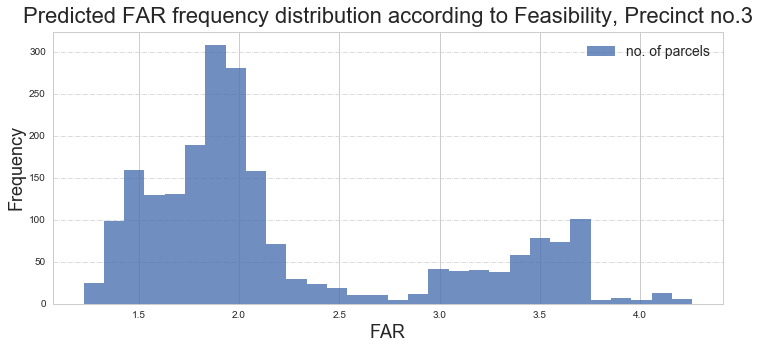

In [135]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

PCT3shp['predictedFAR'].plot(kind="hist", bins=30, label='no. of parcels', alpha=0.8)

ax.set_title("Predicted FAR frequency distribution according to Feasibility, Precinct no.3", fontsize=22, y=1.01)
ax.set_xlabel("FAR", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

### Fig.7 Frequency distribution of anticipated FAR according to feasibility. 
Rezoning utilized only for parcels that were found feasible according to the new ordinance. 

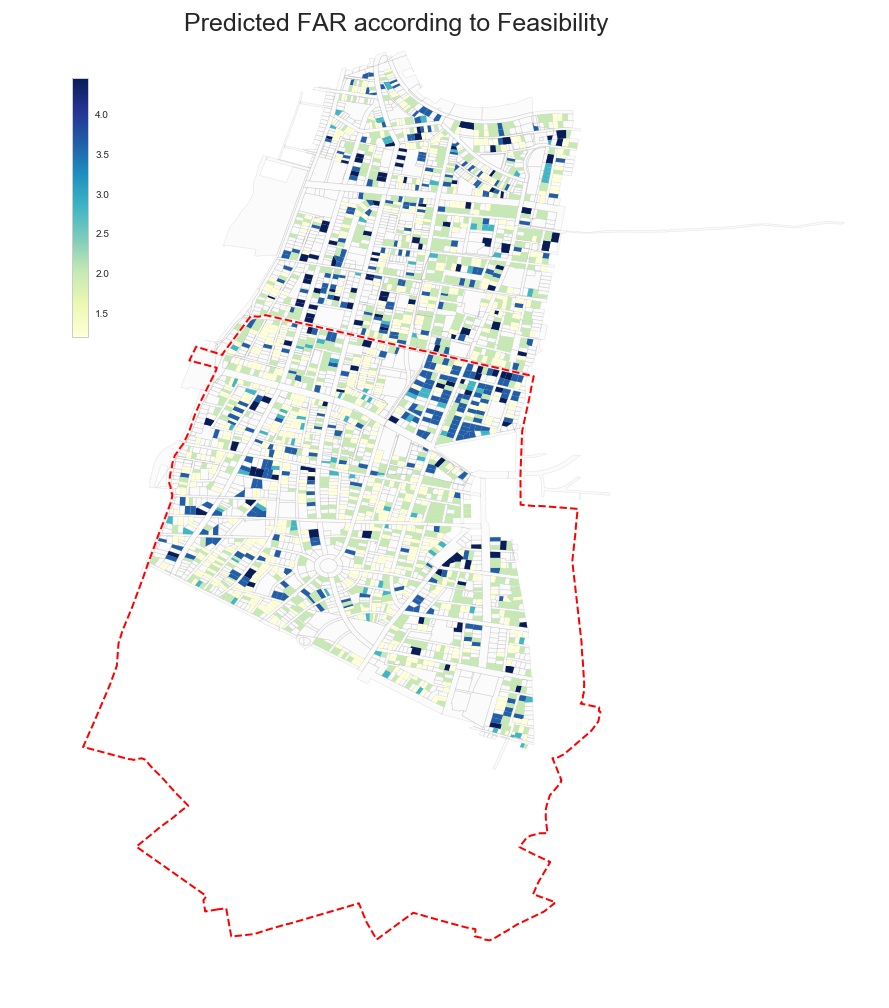

In [136]:
fig = pl.figure(figsize=(15,18))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp[PCT3shp['predictedFAR'] < 4.25].plot(ax=ax, column='predictedFAR', cmap='YlGnBu', scheme='Equal_Interval');
gpd.GeoSeries(WCunion).plot(ax = ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2)

plt.title('Predicted FAR according to Feasibility', size=25, y=.97, x=0.42)

vmin, vmax = 1.2, 4.45

cax = fig.add_axes([0.15, 0.625, .015, 0.2])
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')


tmp = ax.axis('off')

### Fig.8 Anticipated FAR according to feasibility results. 
521 parcels (24%) assumed to be renewed thus show their allowed FAR guided by the rezoning ordinance, while the rest 75% show their current FAR. 

In [137]:
PCT3shp[PCT3shp['Feasibility'] == 1]['FA_new'].sum() - PCT3shp[PCT3shp['Feasibility'] == 1]['FloorArea'].sum()

557536.0011056396

In [138]:
PCT3shp.predictedHUnits.sum() - PCT3shp.hUnits.sum()

3601.0

In [139]:
print("current:", PCT3shp.hUnits.sum())
print("allowed:", PCT3shp.hUnits_new.sum())
print("anticipated:", PCT3shp.predictedHUnits.sum())

current: 30816.0
allowed: 31285.0
anticipated: 34417.0


### The new ordinance is predicted to add 3,390 new housing units to the precinct.

In [140]:
PCT3shp.columns

Index(['ParcelArea', 'geometry', 'BBL', 'Floors', 'footprint', 'height',
       'hUnits', 'FloorArea', 'FAR', 'WhiteCity', 'commerce', 'denscoef',
       'randFootprint', 'footprint_new', 'Floors_new', 'FA_new', 'FAR_new',
       'hUnits_new', 'old/new_FA', 'Feasibility', 'predictedFAR',
       'predictedHUnits'],
      dtype='object')

In [141]:
PCT3short = PCT3shp.drop(['geometry', 'BBL', 'height'], axis=1)
PCT3short.head(3)

ParcelArea  Floors   footprint  hUnits    FloorArea       FAR  WhiteCity  \
0       274.0     3.0  154.417758    12.0   463.253274  1.690705          1   
1       514.0     4.0  252.530801    16.0  1010.123204  1.965220          1   
2       344.0     4.0  171.562549    16.0   686.250196  1.994913          1   

   commerce  denscoef  randFootprint  footprint_new  Floors_new       FA_new  \
0         0        80       0.458320     125.579584        5.65   709.524647   
1         0        80       0.476283     244.809356        6.65  1627.982215   
2         0        80       0.447444     153.920863        5.65   869.652877   

    FAR_new  hUnits_new  old/new_FA  Feasibility  predictedFAR  \
0  2.589506         5.0    0.652907            0      1.690705   
1  3.167281        16.0    0.620476            0      1.965220   
2  2.528061         7.0    0.789108            0      1.994913   

   predictedHUnits  
0             12.0  
1             16.0  
2             16.0

----


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


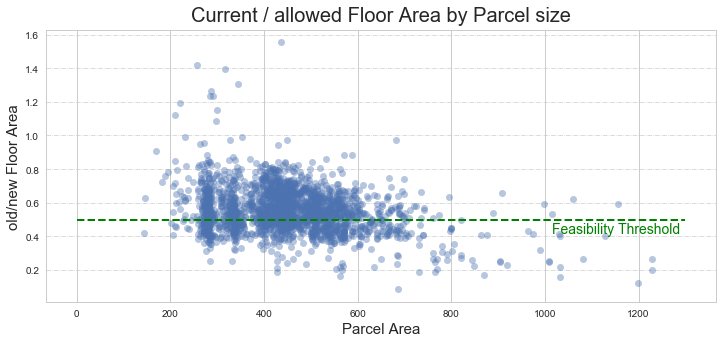

In [243]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

pl.plot(PCT3short['ParcelArea'], PCT3short['old/new_FA'], 'o', alpha=0.4)

ax.set_title("Current / allowed Floor Area by Parcel size", fontsize=20, y=1.01)
ax.set_xlabel("Parcel Area", fontsize=15)
ax.set_ylabel("old/new Floor Area", fontsize=15)
plt.plot((0, 1300),(0.5,0.5), 'g--', linewidth=2)
plt.annotate('Feasibility Threshold', xy=(0.8, 0.6), xytext=(1015, .42),
            arrowprops=dict(facecolor='black', headwidth=0, 
                headlength=0, color='g'),color='g', fontsize=14)

#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.7, axis='y', linestyle='-.')

#plt.legend(fontsize=14)
plt.show()

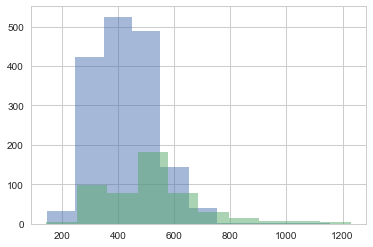

In [244]:
PCT3short['ParcelArea'][PCT3short['Feasibility'] == 0].hist(alpha=0.5)
PCT3short['ParcelArea'][PCT3short['Feasibility'] == 1].hist(alpha=0.5)

## Future research:
- Linear model and non-linear models
- Feature importance / RF: White city yes/no, parcelarea, commercial, building age.. >> Feasibility
- commulative?
- small parcels unification
- precinct 4! 
- different range of footprint? assign to distribution of parcel area?